In [75]:
from copy import deepcopy
from pandas import DataFrame
import scipy
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, balanced_accuracy_score, roc_auc_score, make_scorer,log_loss
from sklearn.model_selection import GridSearchCV
from matplotlib.ticker import StrMethodFormatter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from scipy.optimize import curve_fit

In [76]:
def q2_ranges(dataset):
    q2 = dataset['q2']
    range1 = ((q2 >= 0.1) & (q2 < 0.98)) | ((q2 > 1.1) & (q2 < 8)) | ((q2 > 11) & (q2 < 12.5)) | ((q2 > 15) & (q2 < 19))
    dataset = dataset[range1]
    return dataset[range1]

def apply_all_selection(dataset):
    dataset = q2_ranges(dataset)
    dataset = kstar_vertex_dof(dataset)
    dataset = Kstar_mass(dataset)
    dataset = B0_vertex_dof(dataset)
    dataset = mu_plus_IP(dataset)
    dataset = mu_minus_IP(dataset)
    dataset = K_IP(dataset)
    dataset = Pi_plus_IP(dataset)
    dataset = B0_IP(dataset)
    dataset = B0_FD(dataset)
    dataset = KSTAR_FD(dataset)
    dataset = DIRA(dataset)
    dataset = B0_M(dataset)
    dataset = J_Psi_vertex_dof(dataset)
    dataset = J_Psi_FD(dataset)
    return dataset

In [110]:
Probabilities = [0.9260241275153335,0.9105088052831699,0.9137688241373604,0.9501436326825569,0.9338141020760561,0.9094384363435013,0.9090618727473705,0.9092650077604767,0.9088951621484593,0.9094458260991974,0.9102328038689146,0.9100234879073243,0.9114763516467048,0.9117324304298484,0.9252863305987555,0.9084576958611942,0.9129009292565947,0.9504128777249035,0.9340970198564585,0.9096089371497198,0.9101305554860815,0.9114256256443904,0.9103885309318618,0.9095907548438551,0.9110174917007329,0.9104755595277529,0.910210755700346,0.9115935912465807,0.9163496673849901,0.9149108210457961,0.9512635917378933,0.9460765347897677,0.9108681318337921,0.9094434385036604,0.909015751730185,0.910618697482274,0.9107889131127366,0.9094667450558525,0.9106933019976499,0.9116000024971751,0.9108261351743959,0.9100175197096734,0.9251570905194438,0.9134886342288183,0.9516582366388778,0.9444588086032625,0.9215078182364587,0.9107913714041005,0.9159898881635892,0.9112729318373597,0.9116584626326527,0.9107919291061689,0.9123602948298543,0.911935714665092,0.9107985330577868,0.915202878947385,0.915051238191137,0.9115622429544098,0.9082161593649443,0.9145372906582617,0.91012739769721,0.9093913522445607,0.9094541112035063,0.9229692401914832,0.9102543643082661,0.9102383282932367,0.9086123967692168,0.9102111353219626,0.9109878301721768,0.9102504015047836,0.9091301572999962,0.918800769091057,0.9119992482851506,0.9120290393824757,0.9087193801554618,0.9102540829165389,0.909245696400626,0.9102053957407968,0.9093906715845917,0.919499396448742,0.9100400502346155,0.9110803523166475,0.911043529628715,0.9374157025595129,0.9624066492542483,0.9507984436912207,0.9534218418506255,0.9085855582334346,0.9090818079145536,0.914486531143601,0.9129503298190225,0.9081656286188227]

total_data = pd.read_csv('BackgroundData/total_dataset.csv')
total_data = total_data.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'q2', 'phi', 'costhetal', 'costhetak', 'year'])
Titles = total_data.keys()
Titles = Titles.to_numpy()

In [122]:
def extract_combo_data(dataset, threshold):
    return dataset.loc[(dataset['B0_M'] > threshold)]

def remove_columns(dataset, reject_rows = []):
    #'B0_M', 'J_psi_M', 'q2','Kstar_M'
    dataset_modified = dataset.copy()
    dataset_modified.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'year'], inplace=True)
    
    for i in range (len(Titles) - 1):
        if Probabilities[i] < 0.93:
            dataset_modified.drop(columns=[Titles[i]], inplace=True)
    if 'Unnamed: 0.2' in dataset_modified.columns:
        dataset_modified.drop(columns=['Unnamed: 0.2'], inplace=True)
    
    return dataset_modified

def train_model(X_train,y_train,X_test,y_test):
    model = xgb.XGBClassifier('binary:logistic', missing = np.nan, seed = 42)

    model.fit(X_train,
                y_train,
                eval_metric = 'logloss'
                )

    model.save_model('comb_model_'+str(THRESHOLD)+'_removed_q2_range.model')

    return model

In [123]:
def kstar_vertex_dof(dataset):
    cut_off = 12 * dataset["Kstar_ENDVERTEX_NDOF"].tolist()[0]
    return dataset[dataset['Kstar_ENDVERTEX_CHI2'] < cut_off]

def Kstar_mass(dataset):
     Kstar_M = dataset['Kstar_M']
     range1 = (Kstar_M > 792) & (Kstar_M < 992)
     return dataset[range1]

def B0_vertex_dof(dataset):
    cut_off = 6 * dataset["B0_ENDVERTEX_NDOF"].tolist()[0]
    return dataset[dataset['B0_ENDVERTEX_CHI2'] < cut_off]

def mu_plus_IP(dataset):
    return dataset[dataset['mu_plus_IPCHI2_OWNPV'] > 9]

def mu_minus_IP(dataset):
    return dataset[dataset['mu_minus_IPCHI2_OWNPV'] > 9]

def K_IP(dataset):
    return dataset[dataset['K_IPCHI2_OWNPV'] > 9]

def Pi_plus_IP(dataset):
    return dataset[dataset['Pi_IPCHI2_OWNPV'] > 9]

def B0_IP(dataset):
    return dataset[dataset['B0_IPCHI2_OWNPV'] < 16]

def B0_FD(dataset):
    return dataset[dataset['B0_FDCHI2_OWNPV'] > 121]

def KSTAR_FD(dataset):
    return dataset[dataset['Kstar_FDCHI2_OWNPV'] > 9]

def DIRA(dataset):
    return dataset[dataset['B0_DIRA_OWNPV'] > 0.9999]

def B0_M(dataset):
    B0_M = dataset['B0_M']
    range = (B0_M > 4850) & (B0_M < 5780)
    return dataset[range]

def J_Psi_vertex_dof(dataset):
    cut_off = 12 * dataset["J_psi_ENDVERTEX_NDOF"].tolist()[0]
    return dataset[dataset['J_psi_ENDVERTEX_CHI2'] < cut_off]

def J_Psi_FD(dataset):
    return dataset[dataset['J_psi_FDCHI2_OWNPV'] > 9]

In [124]:
total_data = pd.read_csv('BackgroundData/total_dataset.csv')
signal = pd.read_csv('BackgroundData/signal.csv')

THRESHOLD = 5350

combo_data = extract_combo_data(total_data,THRESHOLD)

signal.loc[:, "target"] = 1
combo_data.loc[:, "target"] = 0

signal = q2_ranges(signal)
combo_data = q2_ranges(combo_data)

signal_clean = remove_columns(signal, ['B0_M', 'J_psi_M', 'q2','Kstar_M', 'mu_plus_PE', 'Pi_ETA'])
combo_data_clean = remove_columns(combo_data, ['B0_M', 'J_psi_M', 'q2','Kstar_M', 'mu_plus_PE', 'Pi_ETA'])

#We then combine the entire dataset.
combine = pd.concat((signal_clean,combo_data_clean), ignore_index=True, axis=0)
#We then shuffle the order and relabel the index.
combine = combine.sample(frac=1)
combine = combine.reset_index(drop=True)



#CREATING THE TRAINING AND TEST DATA
seed = 42
test_size = 0.2
y = combine['target']
X = combine.drop(columns=['target'])
#Creating the three different data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)

model = train_model(X_train,y_train,X_test,y_test)

C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\1006855475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_data.loc[:, "target"] = 0
C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Users\alexa\anaconda3\lib\site-packages\xgboost\core.py:499: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
C:\Users\alexa\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pas

In [125]:
total_data = pd.read_csv('BackgroundData/total_dataset.csv', on_bad_lines='skip')
signal = pd.read_csv('BackgroundData/signal.csv', on_bad_lines='skip')
jpsi_mu_k_swap = pd.read_csv('BackgroundData/jpsi_mu_k_swap.csv', on_bad_lines='skip')
jpsi_mu_pi_swap = pd.read_csv('BackgroundData/jpsi_mu_pi_swap.csv', on_bad_lines='skip')
k_pi_swap = pd.read_csv('BackgroundData/k_pi_swap.csv', on_bad_lines='skip')
phimumu = pd.read_csv('BackgroundData/phimumu.csv', on_bad_lines='skip')
pKmumu_piTok_kTop = pd.read_csv('BackgroundData/pKmumu_piTok_kTop.csv', on_bad_lines='skip')
pKmumu_piTop = pd.read_csv('BackgroundData/pKmumu_piTop.csv', on_bad_lines='skip')
Kmumu = pd.read_csv('BackgroundData/Kmumu.csv', on_bad_lines='skip')
Kstarp_pi0 = pd.read_csv('BackgroundData/Kstarp_pi0.csv', on_bad_lines='skip')
Jpsi_Kstarp_pi0 = pd.read_csv('BackgroundData/Jpsi_Kstarp_pi0.csv', on_bad_lines='skip')

C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3056842147.py:6: DtypeWarning: Columns (12,52) have mixed types. Specify dtype option on import or set low_memory=False.
  phimumu = pd.read_csv('BackgroundData/phimumu.csv', on_bad_lines='skip')


In [126]:
def train_model(X_train,y_train,X_test,y_test):
    model = xgb.XGBClassifier('binary:logistic', missing = np.nan, seed = 42)

    model.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'logloss',
            eval_set = [(X_test,y_test)]
            )

    model.save_model('peaking_model_trained_together_removed_q2_range.model')

    return 

In [127]:
background_models = [jpsi_mu_k_swap,jpsi_mu_pi_swap,k_pi_swap,phimumu,pKmumu_piTok_kTop,pKmumu_piTop,Kmumu,Kstarp_pi0,Jpsi_Kstarp_pi0]
string_background_models = ['jpsi_mu_k_swap','jpsi_mu_pi_swap','k_pi_swap','phimumu','pKmumu_piTok_kTop','pKmumu_piTop','Kmumu','Kstarp_pi0','Jpsi_Kstarp_pi0']
signal.loc[:, "target"] = 1
signal_clean = remove_columns(signal, ['B0_M', 'J_psi_M', 'q2','Kstar_M', 'mu_plus_PE', 'Pi_ETA'])
combine = signal_clean
for idx,x in enumerate(background_models):
    x.loc[:, "target"] = 0

    x = q2_ranges(x)

    background_clean = remove_columns(x, ['B0_M', 'J_psi_M', 'q2','Kstar_M', 'mu_plus_PE', 'Pi_ETA'])

    #We then combine the entire dataset.
    combine = pd.concat((combine,background_clean), ignore_index=True, axis=0)

#We then shuffle the order and relabel the index.
combine = combine.sample(frac=1)
combine = combine.reset_index(drop=True)

#CREATING THE TRAINING AND TEST DATA
seed = 42
test_size = 0.2
y = combine['target']
X = combine.drop(columns=['target'])
#Creating the three different data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify = y)

model = train_model(X_train,y_train,X_test,y_test)

C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[

[0]	validation_0-logloss:0.60484
[1]	validation_0-logloss:0.55692
[2]	validation_0-logloss:0.50882
[3]	validation_0-logloss:0.49058
[4]	validation_0-logloss:0.47384
[5]	validation_0-logloss:0.46115
[6]	validation_0-logloss:0.45341
[7]	validation_0-logloss:0.43826
[8]	validation_0-logloss:0.43472
[9]	validation_0-logloss:0.42718
[10]	validation_0-logloss:0.42304
[11]	validation_0-logloss:0.41784
[12]	validation_0-logloss:0.41583
[13]	validation_0-logloss:0.40998
[14]	validation_0-logloss:0.40895
[15]	validation_0-logloss:0.40636
[16]	validation_0-logloss:0.40486
[17]	validation_0-logloss:0.40432
[18]	validation_0-logloss:0.40316
[19]	validation_0-logloss:0.40264
[20]	validation_0-logloss:0.40067
[21]	validation_0-logloss:0.40018
[22]	validation_0-logloss:0.39746
[23]	validation_0-logloss:0.39651
[24]	validation_0-logloss:0.39518
[25]	validation_0-logloss:0.39419
[26]	validation_0-logloss:0.39384
[27]	validation_0-logloss:0.39274
[28]	validation_0-logloss:0.39222
[29]	validation_0-loglos

In [130]:
def exponential(x,A,d):
    exponential = A*np.exp(-x/d)
    return exponential

def gaussian(x,A,mu,std):
    gaussian = A*np.exp(-(x-mu)**2/(2*std**2))
    return gaussian

def gaussian_exponential(x,A1,mu,std,A2,d):
    exponential_1 = exponential(x,A2,d)
    gaussian_1 = gaussian(x,A1,mu,std)
    f = exponential_1+gaussian_1
    return f

# def two_gaussian_exponential(x,A1,mu1,std1,A2,d,A3,std2):
#     exponential_1 = exponential(x,A2,d)
#     gaussian_1 = gaussian(x,A1,mu1,std1)
#     gaussian_2 = gaussian(x,A3,mu1,std1)
#     f = exponential_1+gaussian_1+gaussian_2
#     return f

#For some reason writing each out is more accurate?
def two_gaussian_exponential(x,A1,mu1,std1,A2,d,A3,std2):
    exponential_1 = A2*np.exp(-x/d)
    gaussian_1 = A1*np.exp(-(x-mu1)**2/(2*std1**2))
    gaussian_2 = A3*np.exp(-(x-mu1)**2/(2*std2**2))
    f = exponential_1+gaussian_1+gaussian_2
    return f



def fit(x,y):
    '''
    Returns the params which decribe the expotenial and guassians which best fit the data.
    '''
    #Trial and error inital guess, I found that these numbers seemed to work best.
    p00=[0.01,5275,15]

    #guesses the parameters for a single gaussian
    par0, cov0 = curve_fit(gaussian,x,y,p0=p00)

    #uses the guesses for the gaussian, to find a more precise guess for a guassian and exponential. Again trail and error used for inital guess.
    p01=list(par0)+[1.7e5,1.9e2]
    par1, cov1 = curve_fit(gaussian_exponential,x,y,p0=p01)

    #Uses previous guesses to find the fit for two gaussians and an expoential.
    p02=list(par1)+[par1[0]]+[par1[2]]

    return curve_fit(two_gaussian_exponential,x,y,p0=p02)

def plot(x,y,dataset,param,bins_n,y_0,y_exp, name_of_graph,dataset_name):
    #Ploting graph
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    x_smooth = np.linspace(min(x),max(x),10000)
    ax.plot(x,y, ".", color='green',label = dataset_name)

    n, bins = np.histogram(dataset['B0_M'],bins = bins_n)
    yerr = np.divide(np.sqrt(n), n,)* y
    ax.errorbar(x,y, yerr = yerr , ls = 'none', color = 'black', elinewidth=1)
    ax.plot(x_smooth,two_gaussian_exponential(x_smooth,*param), color='green', label = "Fitted (2 Gaussian's + Exponential)")
    ax.fill_between(x,y_0,y_exp, color = 'orange',label = 'Combinatorial Background')

    # Layout of graph - From Nick Khoze. ----------------------

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Switch off ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Format y-axis label
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    #----------------------------------------------------------
    plt.xlabel(r'm($K^{+}\pi^{-}\mu^{+}\mu^{-}$) [MeV/$c^{2}$]')
    plt.ylabel(r'Frequency')
    plt.title(name_of_graph)
    plt.ylim(0)
    plt.legend()
    plt.savefig(str(name_of_graph)+'.jpg', bbox_inches="tight", pad_inches=0, format="jpg", dpi=600)
    plt.show()

def remove_columns(dataset, reject_rows = []):
    #'B0_M', 'J_psi_M', 'q2','Kstar_M'
    dataset_modified = dataset.copy()
    dataset_modified.drop(columns=['Unnamed: 0.1','Unnamed: 0', 'year'], inplace=True)
    
    for i in range (len(Titles) - 1):
        if Probabilities[i] < 0.93:
            dataset_modified.drop(columns=[Titles[i]], inplace=True)
    if 'Unnamed: 0.2' in dataset_modified.columns:
        dataset_modified.drop(columns=['Unnamed: 0.2'], inplace=True)
    
    return dataset_modified

C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\3255665451.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return dataset[range1]
C:\Users\alexa\AppData\Local\Temp\ipykernel_10484\2145508750.py:59: RuntimeWarning: invalid value encountered in true_divide
  yerr = np.divide(np.sqrt(n), n,)* y


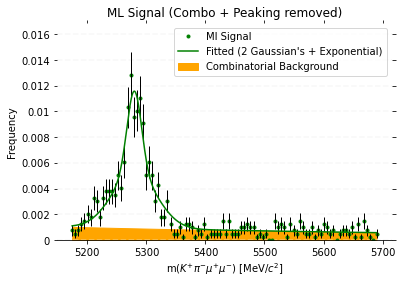

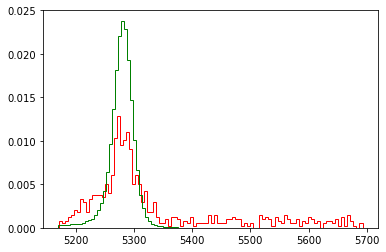

In [142]:
total_data = pd.read_csv('BackgroundData/total_dataset.csv')
#signal_ml = pd.read_csv('Signal_ML_Combo_removed_only.csv')
s_c_dataset = apply_all_selection(total_data)

#------------------------------
'''
Loads in the peaking model and comb models... and applies them.
'''
#boolean controls if the peaking model used is the based off multiple peaking models or just one combined one.
separate = False
directory = 'peaking_models'
training = s_c_dataset.copy()
if separate == True:
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            model = xgb.XGBClassifier()
            model.load_model(f)
            temp_full = training
            training = remove_columns(training, ['B0_M', 'J_psi_M', 'q2','Kstar_M', 'mu_plus_PE', 'Pi_ETA'])
            ypred = model.predict(training)
            training = temp_full.loc[ypred == 1]
elif separate == False:
    peaking_model = xgb.XGBClassifier()
    peaking_model.load_model('peaking_model_trained_together_removed_q2_range.model')
    temp_full = training
    training = remove_columns(training, ['B0_M', 'J_psi_M', 'q2','Kstar_M', 'mu_plus_PE', 'Pi_ETA'])
    ypred = peaking_model.predict(training)
    training = temp_full.loc[ypred == 1]

model = xgb.XGBClassifier()
model.load_model('comb_model_5350_removed_q2_range.model')

temp_full = training

training = remove_columns(temp_full, ['B0_M', 'J_psi_M', 'q2','Kstar_M', 'mu_plus_PE', 'Pi_ETA'])
ypred = model.predict(training)

signal_ml = temp_full.loc[ypred == 1]
comb_ml = temp_full.loc[ypred == 0]

#writes the ml signal to file (peaking and comb applied).
signal_ml.to_csv('ML_SIGNAL_BDT.csv')
#---------------------------------------------------

bins_n = 100

#Calculates histogram for the selection criteria applied dataset.
n_b0_total,bin_edges_b0_total = np.histogram(s_c_dataset['B0_M'],bins = bins_n, density = True)
mid_bin_total = (bin_edges_b0_total[1:]+bin_edges_b0_total[:-1])*0.5

#Calculates histogram for the ml signal dataset.
n_b0_signal,bin_edges_b0_signal = np.histogram(signal_ml['B0_M'],bins = bins_n, density = True)
mid_bin_signal = (bin_edges_b0_signal[1:]+bin_edges_b0_signal[:-1])*0.5

#Calculates histogram for the peaking model removed dataset.
n_b0_peaking,bin_edges_b0_peaking = np.histogram(temp_full['B0_M'],bins = bins_n, density = True)
mid_bin_peaking = (bin_edges_b0_peaking[1:]+bin_edges_b0_peaking[:-1])*0.5

#calculates the parameters used for the fit.
x_total, y_total = mid_bin_total,n_b0_total
x_signal, y_signal = mid_bin_signal,n_b0_signal
x_peaking, y_peaking = mid_bin_peaking,n_b0_peaking

par_total,cov2_total = fit(x_total,y_total)
par_signal,cov2_signal = fit(x_signal,y_signal)
par_peaking,cov2_peaking = fit(x_peaking,y_peaking)

#Gets the exponential terms
y_exp_total=exponential(x_total,par_total[3],par_total[4])
y_0_total=np.zeros(len(y_exp_total))

y_exp_signal=exponential(x_signal,par_signal[3],par_signal[4])
y_0_signal=np.zeros(len(y_exp_signal))

y_exp_peaking=exponential(x_peaking,par_peaking[3],par_peaking[4])
y_0_peaking=np.zeros(len(y_exp_peaking))

#plot(x_total,y_total,s_c_dataset,list(par_total),bins_n,y_0_total,y_exp_total, 'Total Dataset (selection criteria applied)','Total dataset (SC applied)')
plot(x_signal,y_signal,signal_ml,list(par_signal),bins_n,y_0_signal,y_exp_signal, 'ML Signal (Combo + Peaking removed)','Ml Signal')
#plot(x_peaking,y_peaking,temp_full,list(par_peaking),bins_n,y_0_peaking,y_exp_peaking, 'ML Signal (Peaking removed)','Ml Signal')

plt.hist(signal_ml['B0_M'], color="white", ec="Red",bins = bins_n, density = True, histtype='step')
plt.hist(signal["B0_M"], color="white", ec="Green",bins = bins_n, density = True, histtype='step')
plt.show()